In [1]:
# !pip install transformers
# !pip install optuna

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoConfig, BertForSequenceClassification, BartForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import re
import matplotlib.pyplot as plt
from random import sample

device = "mps"

tokenizer = AutoTokenizer.from_pretrained("kabita-choudhary/finetuned-bart-for-conversation-summary", )

model = BartForSequenceClassification.from_pretrained("kabita-choudhary/finetuned-bart-for-conversation-summary", num_labels=2)

Some weights of the model checkpoint at kabita-choudhary/finetuned-bart-for-conversation-summary were not used when initializing BartForSequenceClassification: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at kabita-choudhary/finetuned-bart-for-conversation-summary and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_hea

In [2]:
model = model.to(device)

In [3]:
import json

with open('speakers_facts.json', 'r') as f:
    annotated_data = json.loads(f.read())

In [4]:
remove_blank_facts = lambda x: [fact for fact in x if len(fact) >= 7 or not fact.endswith(':')]
preprocess_fact = lambda x: re.sub(r'^[\*\d]+\.?\s+', '', x)
speaker_mapper = {'facts_s1': 's1', 'facts_s2': 's2'}

annotated_data = [{
    'dialog': dialog['data']['dialogue'], 
    'correct_facts': {speaker_mapper[facts['from_name']]: remove_blank_facts([preprocess_fact(fact) for fact in facts['value']['choices']])
                      for facts in dialog['annotations'][0]['result'] if facts['from_name'] in speaker_mapper.keys()},
    'facts': {'s1': remove_blank_facts([preprocess_fact(fact['value']) for fact in dialog['data']['s1']]), 
              's2': remove_blank_facts([preprocess_fact(fact['value']) for fact in dialog['data']['s2']])},
    'summary': dialog['data']['summary']
        }
    for dialog in annotated_data]

In [5]:
speaker_mapper = {'s1': 'bot_0', 's2': 'bot_1'}

facts_set = {'s1': [fact for data in annotated_data for fact in data['facts']['s1']], 
             's2': [fact for data in annotated_data for fact in data['facts']['s2']]}

dataset = [{
    'dialog': '\n'.join([f'{phrase["author"]}: {phrase["text"]}' 
                         for phrase in dialog['dialog'] 
                        ]),
    'speaker': speaker_mapper[speaker],
    'fact': fact, 
    'target': fact in dialog['correct_facts'].get(speaker, []),
    'summary': dialog['summary']
} for dialog in annotated_data for speaker, facts in dialog['facts'].items() 
    for fact in facts]

In [6]:
from torch.utils.data import Dataset, DataLoader

class ClassifierDataset(Dataset):

    def __init__(self, data):
        super().__init__()

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        sample = self.data[index]

        context = '\n\n'.join(['\n'.join([f'Fact about {sample["speaker"]}:', sample['fact']]),
                               sample['dialog'], ])
        
        target = sample['target']

        return context, target

In [7]:
class Collator:

    def __init__(self, tokenizer, max_length=512):

        self.tokenizer = tokenizer

        self.max_length = max_length

    def __call__(self, batch):

        inputs = []
        targets = []

        for context, target in batch:
            inputs.append(context)
            targets.append(target)

        tokenized_input = self.tokenizer(
            inputs, 
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=self.max_length,
        )

        return tokenized_input, torch.LongTensor(targets)

In [8]:
from random import sample

BATCH_SIZE = 2

train_dataset = ClassifierDataset(data=dataset[:int(len(dataset)*.8)])
valid_dataset = ClassifierDataset(data=dataset[int(len(dataset)*.8):])

collator = Collator(tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

In [9]:
for x, y in train_loader:
    break

In [10]:
from tqdm import tqdm
import numpy as np

def loop(n_epoch, is_train, criterion, optimizer, model, loader, grad_acum_steps=1):
    
    global_step = len(loader) // grad_acum_steps * n_epoch


    all_predictions = list()
    all_targets = list()

    losses = list()
    f1_scores = list()
    accuracies = list()
    rocs = list()

    progress_bar = tqdm(total=len(loader) // grad_acum_steps, desc="Train" if is_train else "Valid")

    if is_train:
        model.train()
    else:
        model.eval()

    losses = list()

    for n_step, (batch, targets) in enumerate(loader):

        batch = batch.to(model.device)
        targets = targets.to(model.device)

        if is_train:
            optimizer.zero_grad()
            logits = model(**batch).logits
        else:
            with torch.no_grad():
                logits = model(**batch).logits

        loss = criterion(logits, targets)

        f1_scores.append(f1_score(targets.detach().cpu(), 
                                  logits.detach().cpu().argmax(1), 
                                  zero_division=False))
        accuracies.append(accuracy_score(targets.detach().cpu(), 
                                         logits.detach().cpu().argmax(1)))
        
        try:
            rocs.append(roc_auc_score(targets.detach().cpu(), 
                                      F.softmax(logits.detach().cpu(), dim=1)[:, 1]))
        except:
            rocs.append(0)
            pass
        
        losses.append(loss.item())

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=0.7)
            optimizer.step()
        progress_bar.update()
        progress_bar.set_postfix(loss=np.mean(losses[-100:]), 
                                 f1_score=np.mean(f1_scores[-100:]),
                                 accuracy=np.mean(accuracies[-100:]), 
                                 roc_auc=np.mean(rocs[-100:]))

        global_step += 1


    progress_bar.close()

    return losses, f1_scores, accuracies, rocs

In [11]:
import optuna
from optuna.trial import TrialState

def define_model(trial):
    pooling_type = "mean"
    dropout = trial.suggest_float("dropout", .1, .7)
    normalize = trial.suggest_int("normalize", False, True)
    embedding_masking = trial.suggest_int("embedding_masking", False, True)

    pooling = GlobalMaskedPooling(pooling_type=pooling_type, normalize=normalize, 
                                  embedding_masking=embedding_masking)
    classifier = Classifier(model, pooling, dropout, 2)
    return classifier

def get_dataset_loaders():
    train_dataset = ClassifierDataset(data=dataset[:int(len(dataset)*.8)])
    valid_dataset = ClassifierDataset(data=dataset[int(len(dataset)*.8):])

    collator = Collator(tokenizer=tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

    return train_loader, valid_loader

def objective(trial):
    model = define_model(trial).to('mps')

    lr = trial.suggest_float("lr", 1e-7, 1e-3, log=True)
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    train_loader, valid_loader = get_dataset_loaders()

    # Training of the model.
    for epoch in range(5):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(model.device)
            target = target.to(model.device)

            optimizer.zero_grad()
            output = model(data, data.attention_mask)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        f1_scores = list()
        outputs = list()
        targets = list()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data = data.to(model.device)
                target = target.to(model.device)

                output = model(data, data.attention_mask)
                # Get the index of the max log-probability.
                pred = output.detach().cpu().argmax(dim=1, keepdim=True)
                correct += pred.eq(target.detach().cpu().view_as(pred)).sum().item()
                
                outputs.extend(F.softmax(output.detach().cpu(), dim=1)[:, 1])
                targets.extend(target.detach().cpu())

        accuracy = correct / len(valid_loader.dataset)
        # f1 = f1_score(targets, outputs)
        roc_auc = 0
        try:
            roc_auc = roc_auc_score(targets, outputs)
        except Exception as e:
            print(e)
            pass

        trial.report(roc_auc, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return roc_auc

In [14]:
criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.AdamW(params=model.parameters(), lr=2e-09)

In [15]:
from tqdm import tqdm

best_valid_loss = np.inf
losses = []
f1_scores = []
accuracies = []
rocs = []

for n_epoch in range(100):
    torch.mps.empty_cache()

    train_losses, train_f1_scores, train_accuracies, train_roc_auc = loop(n_epoch, True, 
                                                                          criterion,
                                                                          optimizer, model, 
                                                                          loader=train_loader)
    valid_losses, valid_f1_scores, valid_accuracies, valid_roc_auc = loop(n_epoch, False,
                                                                          criterion,
                                                                          optimizer, model,
                                                                          loader=valid_loader)

    train_mean_loss = np.mean(train_losses)
    valid_mean_loss = np.mean(valid_losses)

    train_mean_f1_scores = np.mean(train_f1_scores)
    valid_mean_f1_scores = np.mean(valid_f1_scores)

    train_mean_accuracies = np.mean(train_accuracies)
    valid_mean_accuracies = np.mean(valid_accuracies)
    
    train_mean_roc_auc = np.mean(train_roc_auc)
    valid_mean_roc_auc = np.mean(valid_roc_auc)
    
    losses.append(valid_mean_loss)
    f1_scores.append(valid_mean_f1_scores)
    accuracies.append(valid_mean_accuracies)
    rocs.append(valid_mean_roc_auc)

    epoch_message = [
        f"Epoch {n_epoch} done",
        "",
        "Train",
        f"\tLoss: {train_mean_loss:.3f}",
        f"\tF1-score: {train_mean_f1_scores:.3f}",
        f"\tAccuracy: {train_mean_accuracies:.3f}",
        f"\tROC AUC: {train_mean_roc_auc:.3f}",
        "Valid",
        f"\tLoss: {valid_mean_loss:.3f}",
        f"\tF1-score: {valid_mean_f1_scores:.3f}",
        f"\tAccuracy: {valid_mean_accuracies:.3f}",
        f"\tROC AUC: {valid_mean_roc_auc:.3f}",
    ]

    print("\n".join(epoch_message))
    
    if valid_mean_loss > np.mean(losses) or np.isnan(np.mean(losses)):
        print('early stop')
        break

    if valid_mean_loss < best_valid_loss:
        best_valid_loss = valid_mean_loss
        torch.save(model, "best_classifier.pth")
        
torch.save(model, "last_classifier.pth")

Train:  12%|█▏        | 80/677 [14:03<2:01:55, 12.25s/it, accuracy=0.456, f1_score=0.458, loss=0.715, roc_auc=0.237]

KeyboardInterrupt: 

In [17]:
classifier = torch.load('best_classifier.pth')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

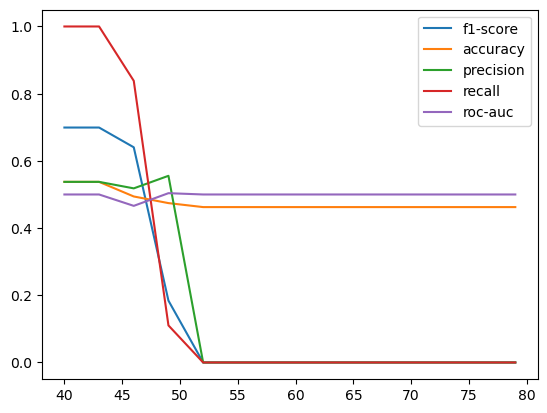

In [18]:
step_threshold = 3
min_threshold, max_threshold = 40, 80

f1_results = []
accuracies = []
precisions = []
recalls = []
roc_aucs = []

thresholds_range = range(min_threshold, max_threshold, step_threshold)

model.eval()

y_hats = []
y_true = []
for n_step, (batch, targets) in enumerate(valid_loader):

    batch = batch.to(classifier.device)

    with torch.no_grad():
        logits = model(**batch).logits

    outputs = F.softmax(logits.detach().cpu(), dim=1)[:, 1]
    
    y_hats.extend(outputs.tolist())
    y_true.extend(targets.tolist())

for i in thresholds_range:
    thresholded_y_hats = np.array(y_hats) > i / 100
    f1_results.append(f1_score(y_true, thresholded_y_hats))
    accuracies.append(accuracy_score(y_true, thresholded_y_hats))
    precisions.append(precision_score(y_true, thresholded_y_hats))
    recalls.append(recall_score(y_true, thresholded_y_hats))
    roc_aucs.append(roc_auc_score(y_true, thresholded_y_hats))
    
plt.plot(thresholds_range, f1_results, label='f1-score')
plt.plot(thresholds_range, accuracies, label='accuracy')
plt.plot(thresholds_range, precisions, label='precision')
plt.plot(thresholds_range, recalls, label='recall')
plt.plot(thresholds_range, roc_aucs, label='roc-auc')

plt.legend()
plt.show()

In [45]:
from random import sample

samples = sample(dataset[-50:], 10)
processed_samples = ['\n\n'.join(['\n'.join([f'Fact about {random_sample["speaker"]}:', 
                                          random_sample['fact']]), 
                                  random_sample['dialog'],]) for random_sample in samples]

In [46]:
print(processed_samples[0])

Fact about bot_1:
bot_1 mentioned that they majored in computer science in college.

bot_0: I like to have money to spend. What is the quickest way to be as rich as you?
bot_1: I inherited some money and used it to develop my company. So I would say that you should find your passion and do what you can to profit from it.
bot_0: Thats good advice.  My only passion right now is helping shelter pets.  I feel so sad that people overlook them because they're not a designer breed.  When are you heading back to Paris?
bot_1: I think you can definitely find a way to make a lot of money by helping animals! Going to college might be a way you can find your passion helping animals. I'm planning on taking my sister there for her birthday.
bot_0: I guess a business degree isn't the worst idea in the world.  I wish I had a sibling who would take me to Paris.  So jealous.  Any special plans while you are there?
bot_1: Lol just regular touristy things. We'll probably go to some cafes, shop around, and

In [47]:
inputs = tokenizer(
            processed_samples, 
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=2048,
        ).to(classifier.device)
with torch.no_grad():
    outputs = classifier(inputs, inputs.attention_mask)

In [52]:
F.softmax(outputs.detach().cpu(), dim=1)[:, 1]

tensor([0.6270, 0.6219, 0.6200, 0.5939, 0.6520, 0.6129, 0.5939, 0.5895, 0.6030,
        0.5751])

In [49]:
[int(random_sample['target']) for random_sample in samples]

[1, 1, 1, 1, 1, 0, 1, 0, 1, 1]

In [50]:
roc_auc_score([int(random_sample['target']) for random_sample in samples], F.softmax(outputs.detach().cpu(), dim=1)[:, 1])

0.6875

In [ ]:
100 - (100 * .1) * 1

90.0

In [ ]:
100 / 1

100.0